
Idea 1 is to use a fitted "oracle" as a proof of concept to label generative instances (data leakage prone). May be worth looking at if the learner is far more onerous to train than the generator for some reason, or as a proof of concept.

Idea 2 is to use a generative model to query, naïvely, a human oracle (```input(...)```) with a single instance (use case here would be lots of unlabeled data for the generator to learn from, but with very few and very expensive _labeled_ instances).

Idea 3 is to do something like the paper. We generate a ton of unlabeled instances per active learning iteration, then via uncertainty sampling choose a few to query either to a human/oracle, or do a nearest neighbors search for real labeled instances (for testing purposes).

Idea 4 is to do what the paper did but implement it in modAL, and also implement a regression version (could be written up too).

In [11]:
!pip install -q sdv

In [17]:
!pip uninstall -y numpy
!pip install numpy

  Using cached https://files.pythonhosted.org/packages/73/ef/8967d406f3f85018ceb5efab50431e901683188f1741ceb053efcab26c87/numpy-1.20.2-cp37-cp37m-manylinux2010_x86_64.whl
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [ ]:
!pip install -q ModAL

In [1]:
import pandas as pd

data = pd.read_csv('./DataPool.csv').dropna()
data

,Mg-glutamate (mM),K-glutamate (mM),Amino Acid (mM),tRNA (mg/ml),coA (mM),NAD (mM),cAMP (mM),Folinic Acid (mM),Spermidine (mM),3-PGA (mM),NTP (mM),Yield
0,4.0,80.0,0.15,0.06,0.078,0.033,0.225,0.0340,0.5,9.0,1.50,12.738
1,2.0,40.0,0.15,0.10,0.026,0.033,0.075,0.0068,0.1,15.0,0.75,5.527
2,4.0,80.0,0.15,0.20,0.026,0.330,0.075,0.0204,0.3,9.0,1.50,19.079
3,1.2,40.0,0.15,0.10,0.026,0.099,0.075,0.0340,0.5,3.0,0.75,9.743
4,4.0,80.0,1.50,0.06,0.130,0.033,0.075,0.0680,0.1,9.0,1.50,27.388
...,...,...,...,...,...,...,...,...,...,...,...,...
1012,4.0,80.0,0.15,0.02,0.026,0.330,0.075,0.0340,0.1,9.0,1.50,20.870
1013,4.0,80.0,1.50,0.10,0.130,0.165,0.075,0.0068,0.3,9.0,1.50,21.862
1014,1.2,40.0,0.15,0.02,0.026,0.099,0.075,0.0068,0.3,15.0,0.75,12.295
1015,0.4,40.0,0.15,0.06,0.026,0.033,0.075,0.0340,0.1,9.0,0.75,7.758


In [2]:
import torch; torch.cuda.is_available()

True

I will evaluate each model on these data to decide what to use for production.

In [34]:
import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
from sdv.tabular import GaussianCopula, CopulaGAN, CTGAN, TVAE

models = [GaussianCopula(), CopulaGAN(), CTGAN(), TVAE()]
for model in tqdm(models):
  model.fit(data)

synthetic_data = [model.sample() for model in models]

In [10]:
synthetic_data[0].head()

,Mg-glutamate (mM),K-glutamate (mM),Amino Acid (mM),tRNA (mg/ml),coA (mM),NAD (mM),cAMP (mM),Folinic Acid (mM),Spermidine (mM),3-PGA (mM),NTP (mM),Yield
0,4.617317,95.733577,0.583477,0.056176,-0.348115,0.073680,-0.049837,0.043459,-0.011255,9.0,1.729016,30.726654
1,5.288661,79.647658,9.490296,0.221329,0.112750,0.267876,0.438881,0.074337,-0.099653,9.0,1.969199,18.763849
2,2.670991,57.818786,0.534681,0.056160,0.080361,0.048326,0.374672,0.042097,0.278411,9.0,1.326400,15.153248
3,2.064969,58.233200,0.863428,0.053389,0.095364,0.035369,0.146137,0.038098,0.150666,9.0,0.860245,18.873069
4,2.533394,59.195608,0.226067,0.064390,0.091400,0.144559,0.202580,0.032006,0.350859,9.0,1.070854,11.776299


In [5]:
from sdv.evaluation import evaluate
evaluations=[evaluate(s_data, data, aggregate=False) for s_data in synthetic_data]

In [6]:
evaluations[0]

,metric,name,raw_score,normalized_score,min_value,max_value,goal
1,LogisticDetection,LogisticRegression Detection,9.468707e-01,0.946871,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,6.970354e-01,0.697035,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-8.220759e+07,0.000000,-inf,inf,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,7.370534e-01,0.737053,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,7.370534e-01,0.737053,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,9.588750e-02,0.095888,0.0,1.0,MAXIMIZE


In [7]:
evaluations[1]

,metric,name,raw_score,normalized_score,min_value,max_value,goal
1,LogisticDetection,LogisticRegression Detection,1.000000e+00,1.000000,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,1.000000e+00,1.000000,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-1.220809e+13,0.000000,-inf,inf,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,6.619141e-01,0.661914,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,6.619141e-01,0.661914,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,1.925615e-01,0.192561,0.0,1.0,MAXIMIZE


In [8]:
evaluations[2]

,metric,name,raw_score,normalized_score,min_value,max_value,goal
1,LogisticDetection,LogisticRegression Detection,2.416907e-01,0.241691,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,2.314053e-02,0.023141,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-1.605513e+07,0.000000,-inf,inf,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,6.821534e-01,0.682153,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,6.821534e-01,0.682153,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,1.782014e-01,0.178201,0.0,1.0,MAXIMIZE


In [11]:
evaluations[3]

,metric,name,raw_score,normalized_score,min_value,max_value,goal
1,LogisticDetection,LogisticRegression Detection,9.571793e-04,0.000957,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,2.900543e-05,0.000029,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-1.394567e+07,0.000000,-inf,inf,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,3.933956e-01,0.393396,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,3.933956e-01,0.393396,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,2.221863e-01,0.222186,0.0,1.0,MAXIMIZE


In [12]:
for i, generated_data in enumerate(synthetic_data):
  print(f'The aggregated evaluation result for {models[i].__class__.__name__} is {evaluate(generated_data, data, aggregate=True)}. \n')

The aggregated evaluation result for GaussianCopula is 0.537593439858. 

The aggregated evaluation result for CopulaGAN is 0.5631656494108904. 

The aggregated evaluation result for CTGAN is 0.3021842704713694. 

The aggregated evaluation result for TVAE is 0.16832051099206413. 



In [35]:
aggregated_evaluations = [evaluate(sd, data, aggregate=True) for sd in synthetic_data]

In [36]:
aggregated_evaluations

[0.5242078713561106,
 0.4667405743521113,
 0.2830937003900395,
 0.1771910322558965]

We can now see how these generative models behave in a supervised setting. This fits a Machine Learning model on the synthetic data and then evaluates it making predictions on the real data.

In [13]:
from sdv.metrics.tabular import LinearRegression, MLPRegressor #only two are built in...

for i, generated_data in enumerate(synthetic_data):
  for regressor in (LinearRegression, MLPRegressor):
    print(f'''
        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model {models[i].__class__.__name__} and regression model {regressor.__name__}
        is {regressor.compute(data,generated_data,target='Yield')}.''')


        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model GaussianCopula and regression model LinearRegression
        is -13.266503943446004.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model GaussianCopula and regression model MLPRegressor
        is -6980.369229257133.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model CopulaGAN and regression model LinearRegression
        is -0.750010067105459.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model CopulaGAN and regression model MLPRegressor
        is -3.0565872071910247.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model CTGAN and regression model LinearRegression
        is 

Given the active learning setting, we also could see how fitting to the real data and then fitting afterward to the fake data could improve performance.

In [14]:
#baseline

for regressor in (LinearRegression, MLPRegressor):
  print(f'''
      The evaluation R^2 result for real training data and real inference/scoring data with regression model {regressor.__name__}
      is {regressor.compute(data,data,target='Yield')}.''')


      The evaluation R^2 result for real training data and real inference/scoring data with regression model LinearRegression
      is 0.804440805414651.

      The evaluation R^2 result for real training data and real inference/scoring data with regression model MLPRegressor
      is 0.06085826531689165.


In [15]:
combined_data=[pd.concat([sd,data]) for sd in synthetic_data]

for i, generated_data in enumerate(combined_data):
  for regressor in (LinearRegression, MLPRegressor):
    print(f'''
        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model {models[i].__class__.__name__} and regression model {regressor.__name__}
        is {regressor.compute(data,generated_data,target='Yield')}.''')


        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model GaussianCopula and regression model LinearRegression
        is 0.7817138394730199.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model GaussianCopula and regression model MLPRegressor
        is -3.0803199792082783.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model CopulaGAN and regression model LinearRegression
        is -0.1867706086850156.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model CopulaGAN and regression model MLPRegressor
        is -174688793301369.25.

        The evaluation R^2 result for synthetic training data and real inference/scoring data with
        generative model CTGAN and regression model LinearRegression
        is

In [16]:
data

,Mg-glutamate (mM),K-glutamate (mM),Amino Acid (mM),tRNA (mg/ml),coA (mM),NAD (mM),cAMP (mM),Folinic Acid (mM),Spermidine (mM),3-PGA (mM),NTP (mM),Yield
0,4.0,80.0,0.15,0.06,0.078,0.033,0.225,0.0340,0.5,9.0,1.50,12.738
1,2.0,40.0,0.15,0.10,0.026,0.033,0.075,0.0068,0.1,15.0,0.75,5.527
2,4.0,80.0,0.15,0.20,0.026,0.330,0.075,0.0204,0.3,9.0,1.50,19.079
3,1.2,40.0,0.15,0.10,0.026,0.099,0.075,0.0340,0.5,3.0,0.75,9.743
4,4.0,80.0,1.50,0.06,0.130,0.033,0.075,0.0680,0.1,9.0,1.50,27.388
...,...,...,...,...,...,...,...,...,...,...,...,...
1012,4.0,80.0,0.15,0.02,0.026,0.330,0.075,0.0340,0.1,9.0,1.50,20.870
1013,4.0,80.0,1.50,0.10,0.130,0.165,0.075,0.0068,0.3,9.0,1.50,21.862
1014,1.2,40.0,0.15,0.02,0.026,0.099,0.075,0.0068,0.3,15.0,0.75,12.295
1015,0.4,40.0,0.15,0.06,0.026,0.033,0.075,0.0340,0.1,9.0,0.75,7.758


We need an Oracle. That is, we want some way to accurately label the generative instances. We can try to train a regressor on all available data and say this is a "ground-truth" approximation.

In [17]:
from sklearn.ensemble import RandomForestRegressor 

regr=RandomForestRegressor()
regr.fit(X=data.drop('Yield',1).values,y=data['Yield'])
regr.score(X=data.drop('Yield',1).values,y=data['Yield'])

0.9893094032224862

In [18]:
synthetic_data[0] #GaussianCopula

,Mg-glutamate (mM),K-glutamate (mM),Amino Acid (mM),tRNA (mg/ml),coA (mM),NAD (mM),cAMP (mM),Folinic Acid (mM),Spermidine (mM),3-PGA (mM),NTP (mM),Yield
0,4.617317,95.733577,0.583477,0.056176,-0.348115,0.073680,-0.049837,0.043459,-0.011255,9.000000,1.729016,30.726654
1,5.288661,79.647658,9.490296,0.221329,0.112750,0.267876,0.438881,0.074337,-0.099653,9.000000,1.969199,18.763849
2,2.670991,57.818786,0.534681,0.056160,0.080361,0.048326,0.374672,0.042097,0.278411,9.000000,1.326400,15.153248
3,2.064969,58.233200,0.863428,0.053389,0.095364,0.035369,0.146137,0.038098,0.150666,9.000000,0.860245,18.873069
4,2.533394,59.195608,0.226067,0.064390,0.091400,0.144559,0.202580,0.032006,0.350859,9.000000,1.070854,11.776299
...,...,...,...,...,...,...,...,...,...,...,...,...
1012,5.263173,108.943734,3.179828,0.062631,0.040595,0.128828,0.292363,0.037292,0.111163,9.000000,1.676344,27.446082
1013,2.528346,63.991771,0.522148,0.172098,0.033230,0.120942,0.040856,0.017787,0.234111,9.000003,1.371796,7.324930
1014,2.690245,65.912843,0.862015,0.066430,-0.064480,0.099502,0.313413,0.019551,-0.264235,9.000005,1.226099,23.655969
1015,5.472466,117.479776,1.250415,0.107548,0.125344,0.317225,0.268182,0.069349,-0.245967,9.000000,2.004066,31.305261


In [19]:
s_data=combined_data[0] #example GaussianCopula
s_targets=s_data['Yield']
s_targets_oracle=regr.predict(s_data.drop('Yield',1))

In [20]:
from sklearn.metrics import r2_score
r2_score(s_targets, s_targets_oracle) #we compare generative labels to random-forest predicted labels, such that the random forest was trained on REAL data

#not a terrible result. This indicates that the random forest is not great at prediction, or the genarative model is not great at label approximation, or both.

#in any event, let a fitted regressor stand-in for an "oracle" for our membership query synthesis!

0.6956924424065434

##MQS steps: we have a budget of 510 additional instances to be labeled via MQS by an oracle. The active learning setup is as follows:

- 1: train an "oracle" on ALL data, even test data.
- 2: Train a query synthesizer to generate instances based on ALL (unlabeled) data available.

- 3: train a freshly instantiated learner on some all available complete feature/label instances (510+507 - test amount)
- 4: generate 510 membership queries and let the "Oracle" label them.
- 5: compare to random sampling.


In [21]:
#from the top:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

data = pd.read_csv('./DataPool.csv').dropna()
oracle=RandomForestRegressor()
oracle.fit(X=data.drop('Yield',1).values,y=data['Yield'])
oracle.score(X=data.drop('Yield',1).values,y=data['Yield'])

0.9895871233915885

We now must generate a held-put test set for evaluation that the synthesizer cannot see.

In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Yield',1), data['Yield'], test_size=0.15, random_state=42)

In [23]:
from sdv.tabular import GaussianCopula

synthesizer = GaussianCopula()
synthesizer.fit(X_train)

synthetic_data=synthesizer.sample() #assess quality of synthesizer

eval = evaluate(synthetic_data, X_train, aggregate=False)
eval

,metric,name,raw_score,normalized_score,min_value,max_value,goal
1,LogisticDetection,LogisticRegression Detection,7.742413e-01,0.774241,0.0,1.0,MAXIMIZE
2,SVCDetection,SVC Detection,1.737076e-01,0.173708,0.0,1.0,MAXIMIZE
11,GMLogLikelihood,GaussianMixture Log Likelihood,-8.312048e+07,0.000000,-inf,inf,MAXIMIZE
13,KSTest,Inverted Kolmogorov-Smirnov D statistic,7.173822e-01,0.717382,0.0,1.0,MAXIMIZE
14,KSTestExtended,Inverted Kolmogorov-Smirnov D statistic,7.173822e-01,0.717382,0.0,1.0,MAXIMIZE
27,ContinuousKLDivergence,Continuous Kullback–Leibler Divergence,8.041749e-02,0.080417,0.0,1.0,MAXIMIZE


We now instantiate a blind learner and start "fresh" with the dataset, such that we have a total of 510 labeling experiments. We can first try with 100 initial instances and 410 membership synthesis queries.

In [24]:
import numpy as np
from tqdm.notebook import tqdm,trange
n_call_to_oracle=410
history=[]
curr_training_pool=X_train.sample(100).values #random

for _ in trange(n_call_to_oracle):
  synthetic_datapoint = synthesizer.sample(1)
  curr_training_pool=np.vstack((curr_training_pool,synthetic_datapoint))
  learner = RandomForestRegressor()
  learner.fit(curr_training_pool,oracle.predict(curr_training_pool))
  history.append(learner.score(X_test,y_test))

Text(0.5, 1.0, 'Pseudo-Oracle Membership Query Synthesis')

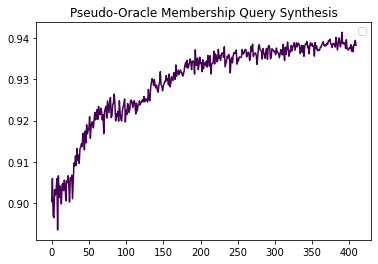

In [26]:
from matplotlib import pyplot as plt
pd.DataFrame(history).plot(colormap='viridis')
plt.legend('')
plt.title('Pseudo-Oracle Membership Query Synthesis')

In [28]:
import copy
from modAL.models import ActiveLearner

def random_sampling(classifier, X_pool):
    n_samples = len(X_pool)
    query_idx = np.random.choice(range(n_samples))
    return query_idx, X_pool[query_idx]

X_train,y_train=X_train.values,y_train.values

n_initial = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

X_pool=copy.deepcopy(X_train)
y_pool=copy.deepcopy(y_train)

X_pool=np.delete(X_pool,initial_idx,axis=0)
y_pool=np.delete(y_pool,initial_idx,axis=0)

learner = ActiveLearner(
    estimator=RandomForestRegressor(),
    query_strategy=random_sampling,
    X_training=X_initial, y_training=y_initial
)

n_call_to_oracle=410

history = []

for _ in trange(n_call_to_oracle):
    query_idx, _ = learner.query(X_pool)
    learner.teach(
        X_pool[query_idx].reshape(1,-1),
        y_pool[query_idx].reshape(1,))
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    r2 = learner.score(X_test,y_test)
    history.append(r2)


Text(0.5, 1.0, 'Random Sampling')

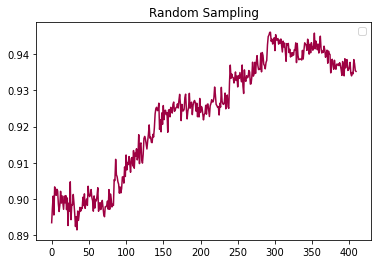

In [29]:
import matplotlib.pyplot as plt

pd.DataFrame(history).plot(colormap='Spectral')
plt.legend('')
plt.title('Random Sampling')

In [30]:
import copy
from modAL.models import ActiveLearner

def GP_regression_std(regressor, X):
    _, std = regressor.predict(X, return_std=True)
    query_idx = np.argmax(std)
    return query_idx, X[query_idx]




from sklearn.model_selection import train_test_split
data = pd.read_csv('./DataPool.csv').dropna()
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Yield',1), data['Yield'], test_size=0.15, random_state=42)

X_train,y_train=X_train.values,y_train.values



from modAL.models import ActiveLearner
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF



n_initial = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)
X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]

X_pool=copy.deepcopy(X_train)
y_pool=copy.deepcopy(y_train)

X_pool=np.delete(X_pool,initial_idx,axis=0)
y_pool=np.delete(y_pool,initial_idx,axis=0)


kernel = RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e3)) \
         + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

learner = ActiveLearner(
    estimator=GaussianProcessRegressor(kernel=kernel),
    query_strategy=GP_regression_std,
    X_training=X_initial, y_training=y_initial
)



n_call_to_oracle=410

history = []

for _ in trange(n_call_to_oracle):
    query_idx, _ = learner.query(X_pool)
    learner.teach(
        X_pool[query_idx].reshape(1,-1),
        y_pool[query_idx].reshape(1,))
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)

    r2 = learner.score(X_test,y_test)
    history.append(r2)

Text(0.5, 1.0, 'GPR Std. Sampling')

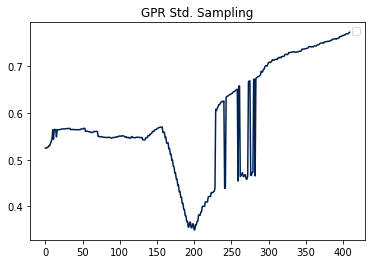

In [31]:
import matplotlib.pyplot as plt

pd.DataFrame(history).plot(colormap='cividis')
plt.legend('')
plt.title('GPR Std. Sampling')

Finished initial MQS implementation. We have a pseudo "oracle" composed of a random forest regressor with access to ALL data, a Gaussian Cupola generator fitted to all unlabeled instances (minus a held-out test set), and a separate random forest learner. I've compared it to random sampling. Note the danger of overfitting is strong here since we have an identical "oracle" to a learner. However, considering the blinded implementation, and if we consider the "oracle" to purely be a high-fidelity labeler, we can see convergence improves in both time and fidelity compared to random sampling.

As such, MQS is compelling when we may learn a good generative model based on ALL unlabeled data, and then spend the experimental budget purely on labeling.

One other side to this: we may generate additional combinations of the design matrix (it was given as a discrete combinatorial problem).

The real weakness here is the overlap in the oracle and serious data leakage. Another way I was thinking of getting around this is to use "pool"-based sampling in modAL, but really alter it significantly such that a generative model is used to either generate naïve instances to be labeled by a human oracle (implemented below), or do something like https://doi.org/10.1016/j.neucom.2014.06.042.

My thought with this was to generate many many instances at each query iteration based on the underlying distribution of the unlabeled dataset, and then use something like uncertainty sampling to choose generated instance to either label by a human, or test out how doing a nearest neighbors search to an existing labeled pool could perform.

## Implementing a ModAL MQS learner.

- without modifying the ActiveLearner class, we can do MQS as follows: consider the active learning "pool" to be a "pool" of unlabeled instances by which we train a generative model. It is up to the user whether this is inclusive or exlcusive of instances seen by the model or not.
- by default, we will use SDV and choose the 

In [6]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import copy


data = pd.read_csv('./DataPool.csv').dropna()
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Yield',1), data['Yield'], test_size=0.15, random_state=42)

In [53]:
data

,Mg-glutamate (mM),K-glutamate (mM),Amino Acid (mM),tRNA (mg/ml),coA (mM),NAD (mM),cAMP (mM),Folinic Acid (mM),Spermidine (mM),3-PGA (mM),NTP (mM),Yield
0,4.0,80.0,0.15,0.06,0.078,0.033,0.225,0.0340,0.5,9.0,1.50,12.738
1,2.0,40.0,0.15,0.10,0.026,0.033,0.075,0.0068,0.1,15.0,0.75,5.527
2,4.0,80.0,0.15,0.20,0.026,0.330,0.075,0.0204,0.3,9.0,1.50,19.079
3,1.2,40.0,0.15,0.10,0.026,0.099,0.075,0.0340,0.5,3.0,0.75,9.743
4,4.0,80.0,1.50,0.06,0.130,0.033,0.075,0.0680,0.1,9.0,1.50,27.388
...,...,...,...,...,...,...,...,...,...,...,...,...
1012,4.0,80.0,0.15,0.02,0.026,0.330,0.075,0.0340,0.1,9.0,1.50,20.870
1013,4.0,80.0,1.50,0.10,0.130,0.165,0.075,0.0068,0.3,9.0,1.50,21.862
1014,1.2,40.0,0.15,0.02,0.026,0.099,0.075,0.0068,0.3,15.0,0.75,12.295
1015,0.4,40.0,0.15,0.06,0.026,0.033,0.075,0.0340,0.1,9.0,0.75,7.758


In [8]:
n_initial = 100
initial_idx = np.random.choice(range(len(X_train)), size=n_initial, replace=False)

X_training, y_training = X_train.iloc[initial_idx], y_train.iloc[initial_idx]

# X_pool=copy.deepcopy(X_train.values)
# y_pool=copy.deepcopy(y_train.values)

# X_pool=np.delete(X_pool,initial_idx,axis=0)
# y_pool=np.delete(y_pool,initial_idx,axis=0)

In [9]:
# defining the custom query strategy, which uses the linear combination of
# classifier uncertainty and classifier margin

def fit_tabular_generator(X:pd.DataFrame, generator = None, return_fitted=True):
    '''
    Train a generator on some initial pool of [tabular] data.

    Keyword arguments:
      X -- the [tabular] feature pool to train a generator on, an np.ndarray or pd.DataFrame
      generator -- an existing SDV.tabular instance, or something with a .sample() method. Make a new one if none provided
      return_fitted -- return an instance of a fitted generator if true, else a newly instantiated model.
    '''
    if generator:
      return generator.fit(X)
    else:

      print('Creating and fitting GaussianCopula, CopulaGAN, CTGAN, and TVAE...')

      from sdv.tabular import GaussianCopula, CopulaGAN, CTGAN, TVAE
      from sdv.evaluation import evaluate

      generators = [GaussianCopula(), CopulaGAN(), CTGAN(), TVAE()]

      for model in generators:
        model.fit(X)
      
      print('Sampling data...')

      synthetic_data = [model.sample() for model in generators]

      print('Evaluating data...')

      aggregated_evaluations = [evaluate(X_synthetic, X, aggregate=True) for X_synthetic in synthetic_data]
      best_idx=np.argmax(aggregated_evaluations)#choose best performing

      print(f'Choosing best generator... \n done.\n Chose {generators[best_idx].__class__.__name__}')

      return generators[best_idx] if return_fitted else [GaussianCopula(), CopulaGAN(), CTGAN(), TVAE()][best_idx]


In [17]:
import warnings
warnings.filterwarnings('ignore')

# generator = fit_tabular_generator(X_training)
from sdv.tabular import GaussianCopula
generator=GaussianCopula()
generator.fit(X_training)

In [50]:
def ask_oracle_for_label(instance,labels,regr_or_clf='regression'):
  '''
  Query oracle for a label. Careful as this does not handle bad inputs and typing!
  '''
  if labels.dtype=='float64':
    possible_labels = labels.describe()
  else:
    possible_labels = np.unique(labels)

  oracle_label = None
  label_type=np.array(possible_labels).dtype

  # Start a loop that will run until the user enters a valid discrete label or a float.
  while not oracle_label:
      # Ask the user for a label.
      oracle_label = input(f"The possible labels for this instance should be from \n {possible_labels}.\n\n \
                        Please provide a suitable dtype {label_type} label for {instance}: ")
      
  return oracle_label

In [51]:
def membership_query_synthesis(generator, human_annotator = True, labels = None,regr_or_clf='regression'): ##, regr_or_clf:str='classification'):
  
    """Generate a synthetic query based on the underlying distribution of some
       inputted "pool" of tabular data, X.

       Note that this could be easily extended to other data modalities,
       such as images, by specifying your own 'generator' object

       Given the synthetic data, we either ask the user for a label
       on this instance and feed it to the learner.

       ***[WIP]***
        Another option is to
        find the nearest real instance
        per https://doi.org/10.1016/j.neucom.2014.06.042
        (only works for classification), and then query an oracle or simply
        pull from the existing labeled pool for testing purposes.


      Keyword arguments:

      X -- the pool that the generator and nearest-neighbors algorithm will draw from.

      generator -- the synthetic [tabular] data generator, based on SDV library.

      human_annotator -- boolean denoting presence of a human annotator.
                If True, asks for a label to the synthetic instance from the human/oracle.

      possible_labels -- optional list of possible labels.
                Recommend to default to unique values or range of values
                based on provided y data in learning loop.

      regr_or_clf -- string specifying whether 'regression' or 'classification' problem.
    """

    X_synthetic = generator.sample(1)
    y_oracle    = ask_oracle_for_label(instance=X_synthetic,labels=labels,regr_or_clf='regression')

    return X_synthetic,y_oracle

We now can query a user for labels to a single generative instance. This is somewhat naïve. a better approach may be to generate a ton of X/y pairs, then use uncertainty sampling, etc, on those instances, then ask for true labels from the oracle for just those features.

To start, here is the naïve method.

In [52]:
from modAL import ActiveLearner
from sklearn.ensemble import RandomForestRegressor

learner = ActiveLearner( #should change, we don't actually sample.
    estimator=RandomForestRegressor(),
    query_strategy=membership_query_synthesis,
    X_training=X_training.values, y_training=y_training.values
)

# pool-based sampling --> MQS
n_queries = 5

for idx in range(n_queries):
    X_synthetic, y_oracle = membership_query_synthesis(generator,labels=y_training, regr_or_clf='regression')
    # typically, we should do learner.query(generator) here.
    # instead, we hope the generative model was useful
    learner.teach(
        X=X_synthetic.values,
        y=np.array([y_oracle]).reshape(-1,)
    )


The possible labels for this instance should be from 
 count    100.00000
mean      14.29433
std        8.20773
min        0.22200
25%        8.13525
50%       13.64450
75%       21.49800
max       32.98300
Name: Yield, dtype: float64.

                         Please provide a suitable dtype float64 label for    Mg-glutamate (mM)  K-glutamate (mM)  ...  3-PGA (mM)  NTP (mM)
0           2.548255         72.746426  ...   16.425252  1.451154

[1 rows x 11 columns]: 4
The possible labels for this instance should be from 
 count    100.00000
mean      14.29433
std        8.20773
min        0.22200
25%        8.13525
50%       13.64450
75%       21.49800
max       32.98300
Name: Yield, dtype: float64.

                         Please provide a suitable dtype float64 label for    Mg-glutamate (mM)  K-glutamate (mM)  ...  3-PGA (mM)  NTP (mM)
0           3.682443         55.098293  ...    5.140474  1.017392

[1 rows x 11 columns]: 4
The possible labels for this instance should be from 
 count

Now, here is the method that uses uncertainty sampling. We generate 100 synthetic instances, then choose a batch of 5 to give to the oracle. We then have two options: we can either do this by human annoatation of these 5 most uncertain generative designs, or we can find the nearest neighbor in the real pool.